### Summary

The following analysis is based on the **Time Series Momentum strategy (TSMOM)** in Moskowitz et al (2012). 

In the paper, the findings are as the following:
1. Strong positive predictability from a security's own past returns for almost five dozen diverse futures and forward contracts
2. Past 12-month exess return of each instrument is positive predictor of its future return
3. The time series momemtum or "trend" persists about an year and then reverses over longer term horizon

In the following sections, we replicate what has been explored in the above-mentioned paper to understand the key findings.

### 1. Data Extraction

For the analysis, we download data provided by "Quantopian". The following futures day includes daily returns of 54 Futures contract from 1984-01-03 to 2009-12-31.

In [1]:
from TSMOM import *
import os
from importlib import reload
import pandas as pd

/Users/nataliekim/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



In [2]:
#DATA SOURCE:'https://github.com/quantopian/research_public/tree/master/advanced_sample_analyses/TSMOM/data'
filename_futures = 'futures.csv'
futures_data = pd.read_csv(filename_futures, parse_dates= True, index_col= [0])

In [3]:
daily_cumulative = futures_data.apply(lambda x: get_eq_line(x, dtime = 'daily'))
monthly_cumulative = futures_data.apply(lambda x: get_eq_line(x))
monthly_volatility = futures_data.apply(lambda x: get_exante_vol(x, com = None))

Text(0, 0.5, 'Cumulative Returns (Log Scale)')

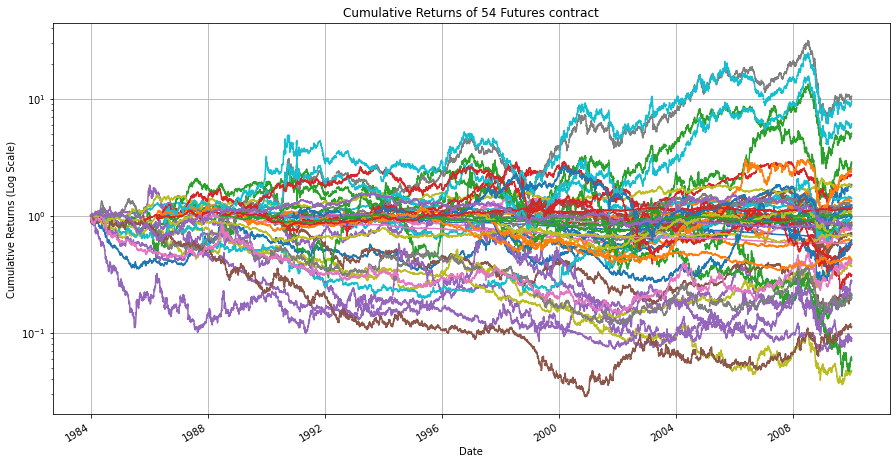

In [4]:
daily_cumulative.plot(figsize = (15, 8), 
               logy = True,
               legend = False, 
               grid = True, 
               title = 'Cumulative Returns of 54 Futures contract')
plt.ylabel('Cumulative Returns (Log Scale)')

As a next step, we calculate the excess returns of futures contract data. To do so, we import private module developed by Ravpritpal Kohli and call "get_excess_rets". This function gets the daily or monthly risk free rate from Fama-French website and subtract it from the returns generated by each futures contract. Then, we map each index tickers to index names for easier interpretation going forward.

In [5]:
futures_excess_returns = get_excess_rets(daily_cumulative, kind = 'arth', freq = 'd', data_type= 'returns' )

In [6]:
filename_futures_list = 'futures_list.csv'
future_name_mapping = pd.read_csv(filename_futures_list)

In [7]:
futures_excess_returns_tranposed = futures_excess_returns.T
futures_excess_returns_tranposed.index.name = 'Asset'
futures_excess_returns_tranposed.reset_index(inplace = True)
merged_dataset = pd.merge(futures_excess_returns_tranposed, future_name_mapping, on= 'Asset')
merged_dataset.sort_values(by = ['asset_class'.upper(), 'futures'.upper()], inplace = True)
merged_dataset.set_index(['asset_class'.upper(), 'futures'.upper()], inplace = True)
del merged_dataset['Asset']
merged_dataset_output = merged_dataset.T

### 2. Data Interpretation

To prove the time series is stationary, we plot the t-statistics of  lagged returns. To do so, we still use the same private library and call get_ts function which calculates t-statistics of lagged returns.

The high t-statistics indicate a strong positive predictibility of the security's past returns, which rejects the null hypothesis of non-predictive returns.

As shown in below graphs in case of bond returns, there is positive predictability of each asset class returns at the beginning and decreases after first 12 months period as the paper suggests. The positive t-statistics for the first 12 months indicate significant return continuation or trend. The negative signs for the longer horizons indicate reversals, the most significant of which occur in the year immediately following the positive trend.

In [8]:
bonds_data = (merged_dataset_output.BOND)
commodity_data = (merged_dataset_output.COMMODITIES)
currency_data = (merged_dataset_output.CURRENCIES)
equity_index_data = (merged_dataset_output['EQUITY INDEXES'])
df_t_stat_bond = get_ts(bonds_data)
df_t_stat_commodity = get_ts(commodity_data)
df_t_stat_currency = get_ts(currency_data)
df_t_stat_equity = get_ts(equity_index_data)

In [9]:
def plot_tstat(df_to_plot):
    fig_lag, axs = plt.subplots(3, 3, 
                            figsize = (16, 10), 
                            facecolor = 'white', 
                            edgecolor = 'k', 
                            )

    plt.suptitle('Lagged t-stats', size = 25)
    axs = axs.ravel()
    fig_lag.subplots_adjust(hspace = 0.5)
    fig_lag.text(0.01, 0.5, 
                 't-stats', 
                 rotation = 90, 
                 va = 'center', 
                 ha = 'center',
                 fontdict = {'fontsize':20}
                )

    fig_lag.text(0.5, 0.05, 
                 'Number of Lags', 
                 rotation = 0, 
                 va = 'center', 
                 ha = 'center',
                 fontdict = {'fontsize':20}
                )
    for i in range(len(df_to_plot.columns[:9])):
        _ax = axs[i]
        ser = df_to_plot.iloc[:, i]
        _ax.set_title('{}'.format(ser.name), fontdict={'fontsize': 12})
        _ax.bar(ser.index, ser.values, width = 0.5, color = 'black')

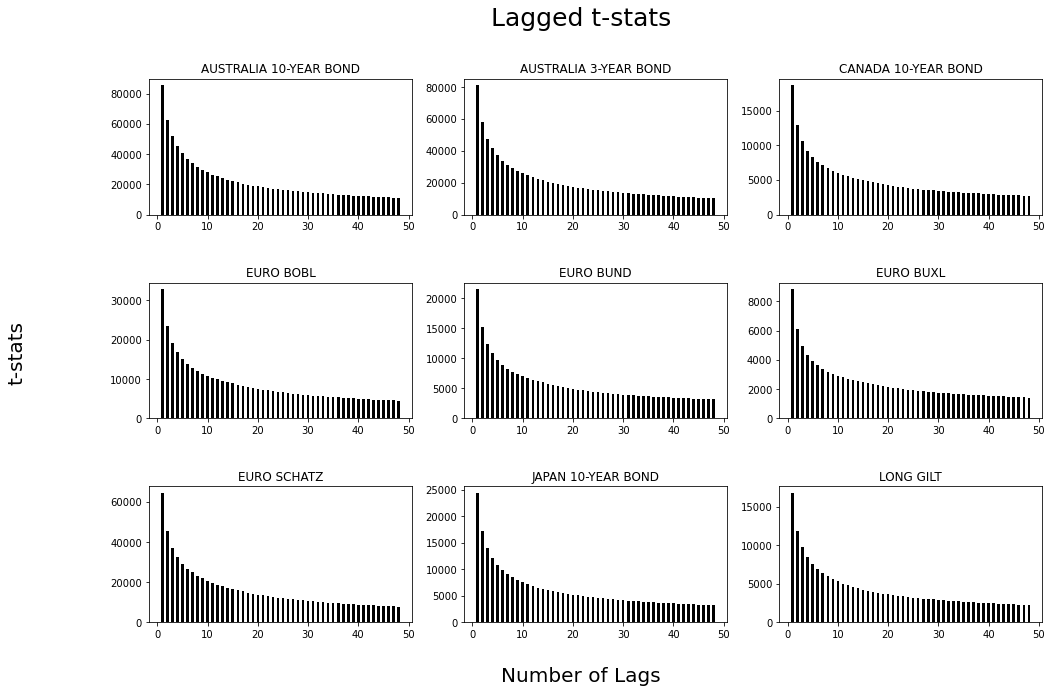

In [10]:
# 1. Plot for bond
plot_tstat(df_t_stat_bond)
# # 2. Plot for bond
# plot_tstat(df_t_stat_commodity)
# # 3. Plot for bond
# plot_tstat(df_t_stat_currency)
# # 4. Plot for bond
# plot_tstat(df_t_stat_equity)

### 3. Constructing Signal

We focus on the properties of the 12-month time series momentum strategy with a 1-month holding period, which we refer to simply as TSMOM. We define TSMOM factor as the following:

$Signal_t^s = {\\rm sign} \\left( r_{t-12, t}^{s} \\right) \\frac{40\\%}{\\sigma_{t}^{s}}\$

where $r_{t-12, t}^{s}$ is a return from time $t-12$ to $t$ for an instrument $s$ and $sigma_{t}^{s}$ is a trailing realised volatility. In addition, the signal is also adjusted by the realised volatility to achieve the target volatility (40%).

To do so, we call get_tsmom_port function in TSMOM library, which yields scaled TSMOM factor return and leverage defined as ${40\\%}/{\\sigma_{t}^{s}}\$.

In [11]:
levered = get_tsmom_port(monthly_volatility, monthly_cumulative, flag = True, scale = 0.2)

### 4. Backtesting

As final step, we conduct backtesting of the proposed signal in section 3 and compare it with benchmark, which is SP 500 returns over the same period. The following result indicates that the strategy return is superior than the benchmark return, which annualized return of 20.15%, volatility of 12.16% and sharpe ratio of 1.657.

In [12]:
levered.loc[:, 'Cumulative VolScale'] = (1 + levered.loc[:, 'TSMOM VolScale']).cumprod()
strat_vol = levered.iloc[:,0]

In [13]:
def backtest(series, freq = 'monthly'):
    port_mean, port_std, port_sr = get_stats(series, freq)
    nmonths = series.shape[0]
    if freq == 'daily':
        nmonths = series.resample('BM').last().shape[0]
    
    print('Back test period for {0} is from {1} to {2} with a total of {3} months \n\n'.format(series.name, 
                                        series.index[0].date().strftime('%b-%Y'), 
                                        series.index[-1].date().strftime('%b-%Y'), 
                                        nmonths))
    print(('Annualized returns for {0} is: {1:,.2%}\nAnnualized volatility for {0} is: {2:,.2%}\nSharpe Ratio for {0} is {3:,.3f}\n\n').format(series.name, 
                                              port_mean, 
                                              port_std, 
                                              port_sr, 
                                               ))

In [14]:
backtest(strat_vol)

Back test period for TSMOM VolScale is from Jan-1985 to Dec-2009 with a total of 300 months 


Annualized returns for TSMOM VolScale is: 20.15%
Annualized volatility for TSMOM VolScale is: 12.16%
Sharpe Ratio for TSMOM VolScale is 1.657




In [15]:
spy_prices = pd.read_csv('spy_returns.csv', index_col = [0], parse_dates= True,dtype= {'Adj Close**': np.float64}, thousands = ',').loc[:, 'Adj Close**']
spy_prices.name = 'SPY'
spy_monthly_cumulative = get_eq_line(spy_prices, data = 'prices', dtime = 'monthly')
spy_monthly_cumulative.iloc[0] = 1
spy_returns = get_rets(spy_prices).dropna().reindex(levered.index)
spy_returns_daily = get_rets(spy_prices, freq= 'd')
spy_mean, spy_std, spy_sr = get_stats(spy_returns_daily, dtime= 'daily')

In [16]:
print('Back test period for {0} is from {1} to {2} with total of {3} months \n\n'
      .format(spy_returns_daily.name,
              spy_returns.index[0].date().strftime('%b-%Y'),
              spy_returns.index[-1].date().strftime('%b-%Y'),
              spy_returns.shape[0]))

print(('Annualized Mean for {3} is: {0:,.2%}\nAnnualized volatility for {3} is: {1:,.2%}\nSharpe Ratio for {3} is {2:,.3f}')
      .format(spy_mean, spy_std, spy_sr, spy_returns.name))

Back test period for SPY is from Jan-1985 to Dec-2009 with total of 300 months 


Annualized Mean for SPY is: 9.39%
Annualized volatility for SPY is: 18.69%
Sharpe Ratio for SPY is 0.502
